# Preparing the environment for EDA

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import squarify
import math


from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from pywaffle import Waffle
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
outer_london = pd.read_csv('Outer_London.csv')

In [3]:
# View Metadata
outer_london.info()

# 375659 rows of data with top row as header
# Survey date has fewer non null rows so will likely have missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375660 entries, 0 to 375659
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Survey wave (year)        375660 non-null  int64 
 1   Site ID                   375660 non-null  object
 2   Location                  375660 non-null  object
 3   Survey date               374492 non-null  object
 4   Weather                   374692 non-null  object
 5   Time                      375660 non-null  object
 6   Period                    375660 non-null  object
 7   Direction                 375660 non-null  object
 8   Start hour                375660 non-null  int64 
 9   Start minute              375660 non-null  int64 
 10  Number of male cycles     375660 non-null  int64 
 11  Number of female cycles   375660 non-null  int64 
 12  Number of unknown cycles  375660 non-null  int64 
 13  Total cycles              375660 non-null  int64 
dtypes: i

In [4]:
# Look at random sample of data
outer_london.sample(5)

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of male cycles,Number of female cycles,Number of unknown cycles,Total cycles
237653,2019,OUTCY053,Edgware Road,"ven, 10/05/19",Dry,1115 - 1130,Inter-peak (10:00-16:00),Southbound,11,15,4,1,0,5
303154,2020,OUTCY163,Long Lane,"jeu, 22/10/20",Dry,1830 - 1845,PM peak (16:00-19:00),Northbound,18,30,1,0,0,1
367061,2021,OUTCY382,Newton Farm Ecology Park,"jeu, 13/05/21",Wet,1615 - 1630,PM peak (16:00-19:00),Westbound,16,15,0,0,0,0
275179,2019,OUTCY347,Yeading Gardens,"jeu, 27/06/19",Dry,1645 - 1700,PM peak (16:00-19:00),Southbound,16,45,1,0,0,1
300396,2020,OUTCY124,Queens Road,"mar, 06/10/20",Dry,1700 - 1715,PM peak (16:00-19:00),Southbound,17,0,1,0,0,1


# Data Wrangling

In [5]:
# Rename columns to remove space in column names
outer_london.columns = outer_london.columns.str.replace(' ','_')

In [6]:
# Parse Dates correctly
# Remove French Day name in Survey Date 
outer_london["Survey_date"] = outer_london["Survey_date"].str.replace(r'\D+', '', regex=True)

# Convert to datetime format
outer_london['Survey_date'] = pd.to_datetime(outer_london.Survey_date)

# Sort DataFrame
outer_london = outer_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])

# Replace with value of previous value row where there is a missing value in Survey_date
outer_london['Survey_date'].fillna(method='ffill', inplace=True)

# Define day of the week in English and add back as a column
outer_london['Day_of_week'] = outer_london['Survey_date'].dt.day_name()

In [7]:
# Pass Month & Season
# Pass Month
outer_london['month'] = outer_london['Survey_date'].dt.month

# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
outer_london['season'] = outer_london['month'].apply(f)

In [10]:
# Check output randomly
outer_london.sample(5)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_male_cycles,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,month,season
179342,2018,OUTCY049,High Road,2018-07-06,Dry,0930 - 0945,AM peak (07:00-10:00),Northbound,9,30,3,0,0,3,Friday,7,Summer
86147,2016,OUTCY223,Durham Road,2016-05-19,Wet,0645 - 0700,Early Morning (06:00-07:00),Northbound,6,45,0,0,0,0,Thursday,5,Spring
125408,2017,OUTCY078,London Road,2017-11-07,Dry,1400 - 1415,Inter-peak (10:00-16:00),Southbound,14,0,1,0,0,1,Tuesday,11,Autumn
80257,2016,OUTCY177,Anson Road,2016-06-22,Dry,0615 - 0630,Early Morning (06:00-07:00),Eastbound,6,15,2,0,0,2,Wednesday,6,Summer
278872,2019,OUTCY376,Belmont Trail,2019-05-06,Dry,1200 - 1215,Inter-peak (10:00-16:00),Southbound,12,0,0,0,0,0,Monday,5,Spring


In [11]:
# Check missing values
outer_london.isnull().sum()

# Relatively small number of missing values. 
# All in Weather column

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                     968
Time                          0
Period                        0
Direction                     0
Start_hour                    0
Start_minute                  0
Number_of_male_cycles         0
Number_of_female_cycles       0
Number_of_unknown_cycles      0
Total_cycles                  0
Day_of_week                   0
month                         0
season                        0
dtype: int64

In [12]:
# View null values in Weather to decide how to deal with them
# First view an example
nan_in_col = outer_london[outer_london['Weather'].isnull()]
print(nan_in_col)

# We can reclassify them as Unknown given no likely relationship with any other observation
# Will do this when looking at Weather column in greater detail

        Survey_wave_(year)   Site_ID               Location Survey_date  \
114304                2016  OUTCY443           Walpole Park  2016-04-25   
114368                2016  OUTCY443           Walpole Park  2016-04-25   
114305                2016  OUTCY443           Walpole Park  2016-04-25   
114369                2016  OUTCY443           Walpole Park  2016-04-25   
114306                2016  OUTCY443           Walpole Park  2016-04-25   
...                    ...       ...                    ...         ...   
59647                 2016  OUTCY015   Lewisham High Street  2021-12-07   
107711                2016  OUTCY391  Greenway (Manor Road)  2021-12-07   
107775                2016  OUTCY391  Greenway (Manor Road)  2021-12-07   
122047                2017  OUTCY052            Pinner Road  2021-12-07   
122111                2017  OUTCY052            Pinner Road  2021-12-07   

       Weather         Time                       Period   Direction  \
114304     NaN  0600 - 0615

In [13]:
# Drop rows where total cycles doesnt add up to number of male, female and unknown cycles
# Creating a column to add up the values
outer_london['Sum'] = outer_london['Number_of_male_cycles'] + outer_london['Number_of_female_cycles'] + outer_london['Number_of_unknown_cycles']

# Dropping rows where the column values dont add up 
outer_london = outer_london[outer_london.Total_cycles == outer_london.Sum]

# Look at output
outer_london.info()

# Only 1 row dropped where total didnt add up

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375659 entries, 6144 to 165759
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Survey_wave_(year)        375659 non-null  int64         
 1   Site_ID                   375659 non-null  object        
 2   Location                  375659 non-null  object        
 3   Survey_date               375659 non-null  datetime64[ns]
 4   Weather                   374691 non-null  object        
 5   Time                      375659 non-null  object        
 6   Period                    375659 non-null  object        
 7   Direction                 375659 non-null  object        
 8   Start_hour                375659 non-null  int64         
 9   Start_minute              375659 non-null  int64         
 10  Number_of_male_cycles     375659 non-null  int64         
 11  Number_of_female_cycles   375659 non-null  int64         
 12 

In [14]:
# Drop the redundant columns
outer_london.drop(['Sum', 'Start_hour', 'Start_minute', 'month'], axis=1)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Number_of_male_cycles,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,season
6144,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Northbound,2,0,0,2,Monday,Winter
6208,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Southbound,10,0,0,10,Monday,Winter
13184,2015,OUTCY104,Osidge Lane,2015-01-05,Dry,0600 - 0615,Early Morning (06:00-07:00),Eastbound,0,0,0,0,Monday,Winter
13248,2015,OUTCY104,Osidge Lane,2015-01-05,Dry,0600 - 0615,Early Morning (06:00-07:00),Westbound,1,0,0,1,Monday,Winter
21760,2015,OUTCY171,Lady Margaret Road,2015-01-05,Cloudy,0600 - 0615,Early Morning (06:00-07:00),Northbound,0,0,0,0,Monday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122111,2017,OUTCY052,Pinner Road,2021-12-07,NaN,2145 - 2200,Evening (19:00-22:00),Southbound,0,0,0,0,Tuesday,Winter
136255,2017,OUTCY163,Long Lane,2021-12-07,N/a,2145 - 2200,Evening (19:00-22:00),Northbound,2,0,0,2,Tuesday,Winter
136319,2017,OUTCY163,Long Lane,2021-12-07,N/a,2145 - 2200,Evening (19:00-22:00),Southbound,0,0,0,0,Tuesday,Winter
165695,2017,OUTCY393,Ferry Lane towpath,2021-12-07,N/a,2145 - 2200,Evening (19:00-22:00),Northbound,1,0,0,1,Tuesday,Winter


In [15]:
# Count unique values in each column
for col in outer_london:
  print(col,": ", outer_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Need to check for double count.
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 123 types of weather needs to be discussed and trimmed with team

Survey_wave_(year) :  7
Site_ID :  451
Location :  431
Survey_date :  435
Weather :  124
Time :  64
Period :  5
Direction :  4
Start_hour :  16
Start_minute :  4
Number_of_male_cycles :  55
Number_of_female_cycles :  20
Number_of_unknown_cycles :  11
Total_cycles :  65
Day_of_week :  7
month :  12
season :  4
Sum :  65


In [16]:
# Explore the different types of Weather
print(outer_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 
# 124 types of weather descriptions

['Good' 'Dry' 'Cloudy' 'Sunny' 'Cloudy/sunny' 'Fine' 'Wet'
 'Cloudy/rain/sunny' 'Cloudy + Sunny' 'Heavy Rain' 'Rain' 'Windy'
 'Fine/dry' 'Fine + Dry' 'Sunny + Cloudy' 'Fine + Hot' 'Cloudy Sunny'
 'Sun Setting' 'Dry/cold' 'Dry Chill' 'Dry/mild' 'Cold' 'Cold/sunny'
 'Dry Cold' 'Cold/cloudy' 'Sunny Overcast' 'Sunny/cloudy'
 'Bright + Cloudy' 'Dark/dry' 'Dry/good' 'Dry Dark' 'Dry/sunny' 'Dry/dark'
 'Showers' 'Wet/windy' 'Rain/cloudy' 'Raining' 'Cloudy/windy'
 'Windy + Sunny' 'Dry/windy' 'Sunsetting + Windy' 'Wet/dry'
 'Cloudy + Rain' 'Rain & Cloudy' 'Cloudy/dry' 'Bright' 'Partly Sunny'
 'Wet/v.windy' 'Dry Very Windy' 'Dark Cloudy' 'Dark Dry' 'Warm + Dry'
 'Dull' 'Intermittent Drizzle' 'Light Showers' 'Dry & Sunny' 'Drizzle'
 'Dry/wet' nan 'Sleet' 'Shower' 'Dry V. Cold!' 'Dry & Sun' 'Snow!'
 'Thunder Lightening Rain!' 'Wet Hail' 'Rain Heavy Showers' 'Rain/hail'
 'Snow' 'Down Pour' 'Deluge' 'Very Wet' 'Heavy Showers'
 'Intermittent Light Drizzle' 'Heavy Shower' 'Light Rain' 'Dry & Mild'
 'Fi

In [26]:
# Replace some obvious duplications in Weather
# Rain
outer_london['Weather'] = outer_london['Weather'].replace(['Wet','Showers','Rain','Cloudy + Rain','Rain & Cloudy',
                                                          'Raining', 'Rain/cloudy','Wet/thunder','Light Showers',
                                                          'Rain/showers','W','Wey','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)'],'Rain')

# Good
outer_london['Weather'] = outer_london['Weather'].replace(['Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy with clear spells',
                                                          'Sunny Overcast', 'Sunny','Cloudy Sunny','Sun Setting','Good',
                                                           'Dry/sunny','Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry','Warm + Dry','D'],'Good')
# Damp
outer_london['Weather'] = outer_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle',
                                                           'Light Rain','Lt Rain','Drizzle','Intermittent Drizzle', 'Damp',
                                                           'Getting Dry','Dry & Wet','Dry/wet',],'Damp')


# Dangerous Conditions
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Chill','Dry/cold','Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Wet/windy','Wet/v.windy','Wet Hail',
                                                           'Rain/hail','Foggy Wet','Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot','Dry (road Wet)'],
                                                          'Dangerous_Conditions')

# Replacing nan with 'Unknown'
outer_london.Weather = outer_london.Weather.fillna('Unknown')

# Consolidating "Unknown"
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry','Dark Dry', 'N/a'],'Unknown')

In [27]:
# Check output
print(outer_london.Weather.unique())

['Good' 'Rain' 'Dangerous_Conditions' 'Unknown' 'Damp']


# Basic Visualisations

## How has cycling evolved over time?


In [19]:
# Aggregate data by survey year
df= outer_london.groupby(['Survey_wave_(year)'], as_index=False)['Total_cycles'].sum()
df

,Survey_wave_(year),Total_cycles
0,2015,82226
1,2016,80295
2,2017,86588
3,2018,91966
4,2019,82117
5,2020,74924
6,2021,99067


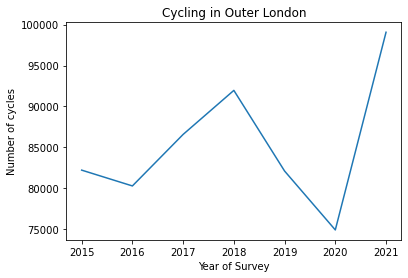

In [20]:
# Create the line chart
plt.plot(df['Survey_wave_(year)'], df['Total_cycles'])

# Adding the aesthetics
plt.title("Cycling in Outer London")
plt.xlabel('Year of Survey')
plt.ylabel('Number of cycles')

# Show the plot
plt.show()

## Does time of the day matter?

In [21]:
# Aggregate by time of day

df= outer_london.groupby(['Period'], as_index=False)['Total_cycles'].sum()
df.sort_values('Total_cycles', inplace = True)

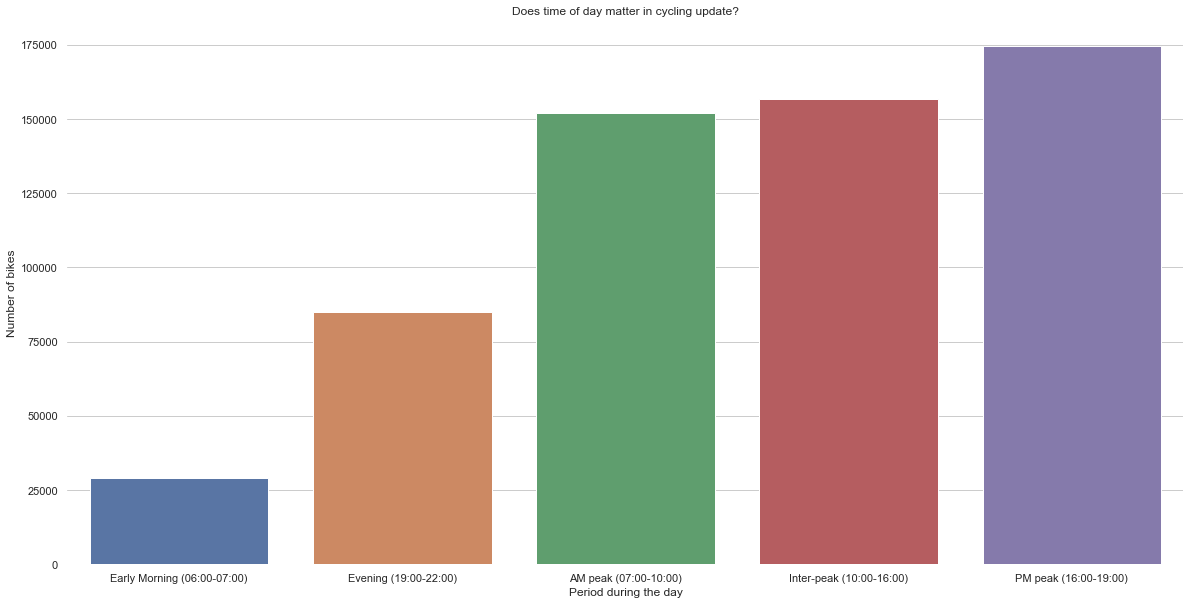

In [22]:
# Chart to view time of day with highest cycling count
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (20,10))

g=sns.barplot(x = df['Period'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Period during the day")
g.set_title('Does time of day matter in cycling update?')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

# PM Peak has highest number of cycling trips

## Do Seasons make a difference?

In [23]:
# Aggregate data by Weather
df= outer_london.groupby(['season'], as_index=False)['Total_cycles'].sum()
df

,season,Total_cycles
0,Autumn,121084
1,Spring,222693
2,Summer,207195
3,Winter,46211


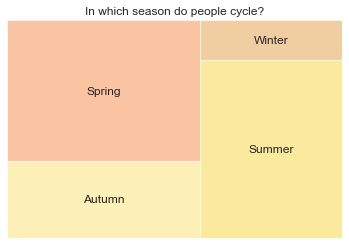

In [24]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["Total_cycles"].values
label=df["season"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='In which season do people cycle?')
plt.axis('off')
plt.show()

# Need to ask Kevin to prettify
# Explore waffle charts
# Clearly seasons have a large impact
# Or is it bcz of the period in which data has been collected? 
# Count shows bulk of data collected in spring and summer 
# Need to check

## Does Weather Matter?

In [28]:
# Aggregate data by Weather
df= outer_london.groupby(['Weather'], as_index=False)['Total_cycles'].sum()
df
# Clearly a big factor. But how does this compare to other cities? 
# For within each condition what % of London is on bike versus their peers in other cities?

,Weather,Total_cycles
0,Damp,683
1,Dangerous_Conditions,927
2,Good,536883
3,Rain,51835
4,Unknown,6855


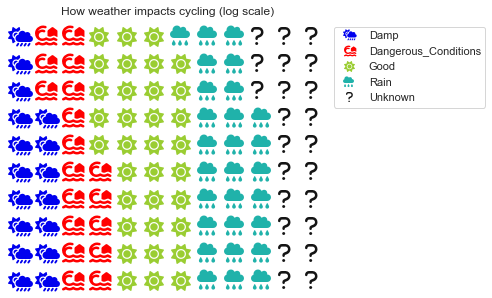

In [29]:
# Plot Waffle Chart
# Change to log scale
fig = plt.figure(
    FigureClass=Waffle,
    rows=10, columns = 12, figsize = (7,15), title = {'label': 'How weather impacts cycling (log scale)'},
    values=[math.log(683), math.log(927), math.log(536883), math.log(51835), math.log(6855)],
    colors=["#0000EE", "#FF0000", "#9ACD32", "#20B2AA", "#141414"],
    icons=['cloud-sun-rain', 'house-tsunami', 'sun', 'cloud-rain', 'question'],
    font_size=20,
    icon_style='solid',
    icon_legend=True,
    legend={
        'labels': ['Damp', 'Dangerous_Conditions', 'Good', 'Rain', 'Unknown'], 
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1)
    }
)


In [ ]:
# Plot Stacked Bar Chart as an alternative maybe?
# For Kevin

In [ ]:
# Explore combination of other variables